# Waymo Open Dataset Motion Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates:
- How to decode and interpret the data.
- How to train a simple model with Tensorflow.

Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use, open this notebook in [Colab](https://colab.research.google.com).

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".

# What does the data look like

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import math
import os
import uuid
import time

from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import numpy as np
from IPython.display import HTML
import itertools
import tensorflow as tf

from google.protobuf import text_format
from waymo_open_dataset.metrics.ops import py_metrics_ops
from waymo_open_dataset.metrics.python import config_util_py as config_util
from waymo_open_dataset.protos import motion_metrics_pb2
from waymo_open_dataset.protos import scenario_pb2

files = glob.glob("/files/waymo/scenario/training/training*", recursive=False)

dataset = tf.data.TFRecordDataset(files[0], compression_type='') # serialized scenario
data = next(dataset.as_numpy_iterator())

scenario = scenario_pb2.Scenario.FromString(data)

2025-05-30 11:54:42.536572: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 11:54:42.601688: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 11:54:42.602816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-30 11:54:43.514772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-05-30 11:54:45.197721: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for ho

In [3]:
from data_preprocess import process_waymo_data_with_scenario_proto

info = process_waymo_data_with_scenario_proto(files[0], ".")

In [4]:
index = 0

In [5]:
list(info[index].keys())

['track_infos',
 'dynamic_map_infos',
 'map_infos',
 'scenario_id',
 'timestamps_seconds',
 'current_time_index',
 'sdc_track_index',
 'objects_of_interest',
 'tracks_to_predict']

In [6]:
len(info[index]["timestamps_seconds"])

91

In [7]:
info[index]["track_infos"]["trajs"].shape

(233, 91, 10)

In [ ]:
info[index]["map_infos"]["lane"]

## Visualizing Number of Classes and Occlusions

In [47]:
from waymo_types import object_type, lane_type, road_line_type, road_edge_type, signal_state, polyline_type
from collections import defaultdict

occlusions = []
object_counts = {} # type --> count
for file in files:
    dataset = tf.data.TFRecordDataset(file, compression_type='') # serialized scenario
    data = next(dataset.as_numpy_iterator())

    scenario = scenario_pb2.Scenario.FromString(data)
    occlusion_count = 0
    for track in scenario.tracks:
        if object_type[track.object_type] not in object_counts:
            object_counts[object_type[track.object_type]] = 0
        object_counts[object_type[track.object_type]] += 1
        for state in track.states:
            if not state.valid:
                occlusion_count += 1
    occlusions.append(occlusion_count)

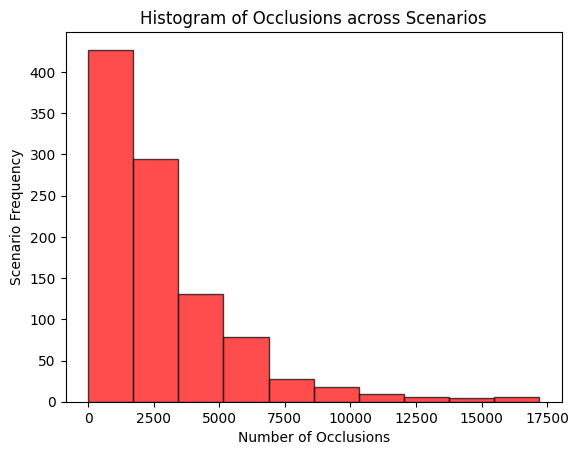

In [78]:
import matplotlib.pyplot as plt

plt.hist(occlusions, bins=10, color='red', edgecolor='black', alpha=0.7)
plt.title("Histogram of Occlusions across Scenarios")
plt.xlabel("Number of Occlusions")
plt.ylabel("Scenario Frequency")
plt.savefig("occlusions.png")

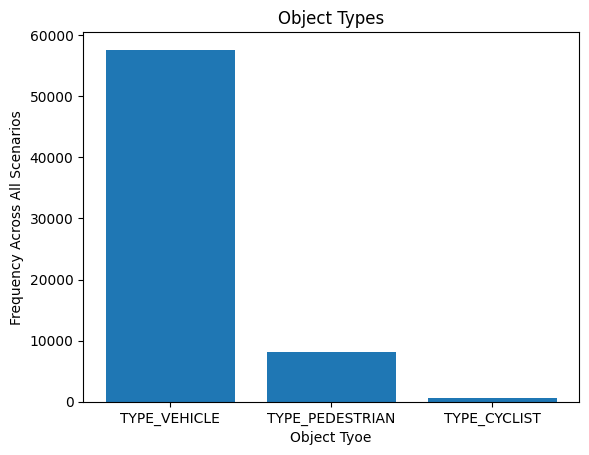

In [81]:
plt.bar(list(object_counts.keys()), list(object_counts.values()))
plt.title("Object Types")
plt.xlabel("Object Tyoe")
plt.ylabel("Frequency Across All Scenarios")
plt.savefig("objecttypes.png")